In [1]:
import os
import shutil
import cv2
import json
import numpy as np
from tqdm.notebook import tqdm
import torchvision.transforms.functional as TF
import random
from torchvision.transforms import ColorJitter
from PIL import ImageFilter
import os
import json
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from collections import OrderedDict
from PIL import Image

In [7]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.
    The angle should be given in radians.
    
    modified from answer here: https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return int(qx), int(qy)
    
from torch.utils.data import Dataset

class LandmarksDataset_from_json(Dataset):
    def __init__(self, root_dir, json_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        with open(json_file, 'r') as f:
            self.data = json.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = list(self.data.keys())[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = cv2.imread(img_path)
        info = self.data[img_name]
        bbox = info['bbox']
        landmarks = np.array(info['landmarks'])

        if self.transform:
            image, bbox, landmarks = self.transform(image, bbox, landmarks)

        return image, bbox, landmarks

class LandmarksAugmentation:
    def __init__(self, rotation_limit, bbox_jitter_scale):
        self.rotation_limit = rotation_limit
        self.bbox_jitter_scale = bbox_jitter_scale

    def random_rotation(self, image, bbox, landmarks):
        angle = transforms.RandomRotation.get_params(degrees=(-self.rotation_limit, self.rotation_limit))
        image = transforms.ToPILImage()(image)
        center = (image.size[1] / 2, image.size[0] / 2)
        image = transforms.functional.rotate(image, -angle, center=center) # absolutely stupid bug, everything starts working with -angle here
        landmarks = self.rotate_landmarks(landmarks, angle, image.size)
        bbox = self.rotate_bbox(bbox, angle, image.size)
        return image, bbox, landmarks

    def rotate_bbox(self, bbox, angle, image_size):
        """
        Rotate a bounding box counterclockwise by a given angle around a given center point.
        The angle should be given in radians.
        """
        # Convert the bounding box to four points: topleft, btmleft, btmright, topright
        pt1 = [bbox[0], bbox[1]]  # topleft
        pt2 = [bbox[0], bbox[3]]  # btmleft
        pt3 = [bbox[2], bbox[3]]  # btmright
        pt4 = [bbox[2], bbox[1]]  # topright

        center = (image_size[1] / 2, image_size[0] / 2)
        
        # Rotate each point
        rotated_pt1 = rotate(center, pt1, math.radians(angle))
        rotated_pt2 = rotate(center, pt2, math.radians(angle))
        rotated_pt3 = rotate(center, pt3, math.radians(angle))
        rotated_pt4 = rotate(center, pt4, math.radians(angle))
        
        # Calculate the bounding box of the rotated points
        x_min = min(rotated_pt1[0], rotated_pt2[0], rotated_pt3[0], rotated_pt4[0])
        y_min = min(rotated_pt1[1], rotated_pt2[1], rotated_pt3[1], rotated_pt4[1])
        x_max = max(rotated_pt1[0], rotated_pt2[0], rotated_pt3[0], rotated_pt4[0])
        y_max = max(rotated_pt1[1], rotated_pt2[1], rotated_pt3[1], rotated_pt4[1])
        
        return [x_min, y_min, x_max, y_max]
    
    def rotate_landmarks(self, landmarks, angle, image_size):
        # Calculate center of the image
        center = (image_size[1] / 2, image_size[0] / 2)
    
        # Initialize list to store rotated landmarks
        rotated_landmarks = []
    
        # Rotate each landmark point
        for point in landmarks:
            rotated_point = rotate(center, point, math.radians(angle))
            rotated_landmarks.append(rotated_point)
    
        return rotated_landmarks

    
    def bbox_jitter(self, bbox):
        bbox = torch.tensor(bbox)
        bbox_center = (bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2
        bbox_width = bbox[2] - bbox[0]
        bbox_height = bbox[3] - bbox[1]
        jittered_width = bbox_width * np.random.uniform(1 - self.bbox_jitter_scale, 1 + self.bbox_jitter_scale)
        jittered_height = bbox_height * np.random.uniform(1 - self.bbox_jitter_scale, 1 + self.bbox_jitter_scale)
        jittered_bbox = [bbox_center[0] - jittered_width / 2, bbox_center[1] - jittered_height / 2, 
                         bbox_center[0] + jittered_width / 2, bbox_center[1] + jittered_height / 2]
        return jittered_bbox

    def __call__(self, image, bbox, landmarks):
        
        # Apply random rotation
        image, bbox, landmarks = self.random_rotation(image, bbox, landmarks)
        
        # Apply bbox jitter
        jittered_bbox = self.bbox_jitter(bbox)
        
        return image, jittered_bbox, landmarks 



def visualize(image, bbox, landmarks, img_path, selected_indices=None):
    bbox = np.array(bbox)  # Convert bounding box to NumPy array
    landmarks = np.array(landmarks)  # Convert landmarks to NumPy array
    
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='g', facecolor='none'))
    
    if selected_indices is not None:
        selected_landmarks = landmarks[selected_indices]
        for landmark in selected_landmarks:
            plt.scatter(landmark[0], landmark[1], c='r', s=20)
    
    plt.axis('off')
    plt.title(f"Image Path: {img_path}")
    plt.show()


class FaceHorizontalFlip68:
    def __init__(self, p=0.5):
        self.p = p
        self.flip = transforms.RandomHorizontalFlip(p=1)

    def __call__(self, image, bbox, landmarks):
        if torch.rand(1) < self.p:
            image_pil = transforms.ToPILImage()(image)
            image_pil = self.flip(image_pil)
            image = transforms.ToTensor()(image_pil)
            width = image.shape[2]
            flipped_bbox = self.flip_bbox(bbox, width)
            flipped_landmarks = torch.tensor(landmarks).clone()
            flipped_landmarks[:, 0] = width - 1 - flipped_landmarks[:, 0]
            flipped_landmarks = self.reorder_landmarks(flipped_landmarks)
            return image, flipped_bbox, flipped_landmarks
        return image, bbox, landmarks

    def flip_bbox(self, bbox, width):
        bbox_tensor = torch.tensor(bbox)
        flipped_bbox = bbox_tensor.clone()
        flipped_bbox[0], flipped_bbox[2] = width - 1 - bbox_tensor[2], width - 1 - bbox_tensor[0]  # Flip left and right coordinates
        return flipped_bbox.tolist()  # Convert back to list before returning

    def reorder_landmarks(self, landmarks):
        mapping = {
            # face countor
            1: 17,
            2: 16,
            3: 15,
            4: 14,
            5: 13,
            6: 12,
            7: 11,
            8: 10,
            9: 9,

            10: 8,
            11: 7,
            12: 6,
            13: 5,
            14: 4,
            15: 3,
            16: 2,
            17: 1,

            # brows
            18: 27,
            19: 26,
            20: 25,
            21: 24,
            22: 23,

            23: 22,
            24: 21,
            25: 20,
            26: 19,
            27: 18,

            # nose
            28: 28,
            29: 29,
            30: 30,
            31: 31,

            # nostrils
            32: 36,
            33: 35,
            34: 34,

            35: 33,
            36: 32,

            # eyes
            37: 46,
            38: 45,
            39: 44,
            40: 43,
            41: 48,
            42: 47,

            43: 40,
            44: 39,
            45: 38,
            46: 37,
            47: 42,
            48: 41,

            # lips
            49: 55,
            50: 54,
            51: 53,
            52: 52,
            53: 51,
            54: 50,
            55: 49,
            56: 60,
            57: 59,
            58: 58,
            59: 57,
            60: 56,
            61: 65,
            62: 64,
            63: 63,
            64: 62,
            65: 61,
            66: 68,
            67: 67,
            68: 66
        }
        
        flipped_landmarks = landmarks.clone()
        for key, value in mapping.items():
            flipped_landmarks[key - 1] = landmarks[value - 1]
        return flipped_landmarks



class AddNoise:
    def __init__(self, min_noise_scale, max_noise_scale, noise_prob):
        self.min_noise_scale = min_noise_scale
        self.max_noise_scale = max_noise_scale
        self.noise_prob = noise_prob

    def __call__(self, image, bbox, landmarks):
        # Randomly decide whether to add noise
        if random.random() < self.noise_prob:
            # Sample noise scale from the specified range
            noise_scale = random.uniform(self.min_noise_scale, self.max_noise_scale)

            # Convert image to tensor
            image_tensor = TF.to_tensor(image)
            
            # Add noise to the tensor
            noisy_image_tensor = image_tensor + torch.randn_like(image_tensor) * noise_scale
            
            # Convert back to PIL Image
            noisy_image = TF.to_pil_image(noisy_image_tensor)
        else:
            noisy_image = image
        
        return noisy_image, bbox, landmarks

class GaussianBlur:
    def __init__(self, probability, min_sigma, max_sigma):
        self.probability = probability
        self.min_sigma = min_sigma
        self.max_sigma = max_sigma

    def __call__(self, image, bbox, landmarks):
        if random.random() < self.probability:
            sigma = random.uniform(self.min_sigma, self.max_sigma)
            blurred_image = image.filter(ImageFilter.GaussianBlur(sigma))
            return blurred_image, bbox, landmarks
        else:
            return image, bbox, landmarks


class CustomColorJitter:
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.color_jitter = ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)

    def __call__(self, image, bbox, landmarks):
        return self.color_jitter(image), bbox, landmarks

class CropAndResize:
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, image, bbox, landmarks):
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        # Extract bbox coordinates
        x_min, y_min, x_max, y_max = bbox
        
        # Ensure integer values for coordinates
        x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
        
        # Crop the image using bbox coordinates
        cropped_image = TF.crop(image, y_min, x_min, y_max - y_min, x_max - x_min)
        
        # Resize the cropped image to the specified output size
        resized_image = TF.resize(cropped_image, [self.output_size, self.output_size])
        
        # Normalize landmarks to the bbox
        landmarks_normalized = []
        bbox_width = x_max - x_min
        bbox_height = y_max - y_min
        
        for x, y in landmarks:
            if x_min <= x <= x_max and y_min <= y <= y_max:
                x_new = (x - x_min) / bbox_width
                y_new = (y - y_min) / bbox_height
                landmarks_normalized.append([x_new, y_new])
            else:
                landmarks_normalized.append([-1, -1])
        
        return resized_image, bbox, landmarks_normalized

class NormalizeAndToTensor:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __call__(self, image, bbox, landmarks):
        
        # Apply the composed transform to the image
        tensor_image = self.transform(image)
        landmarks = torch.flatten(torch.tensor(landmarks, dtype=torch.float32))
        return tensor_image, bbox, landmarks

class CustomTransform:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, bbox, landmarks):
        for t in self.transforms:
            image, bbox, landmarks = t(image, bbox, landmarks)
        return image, bbox, landmarks

class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, c, h, w].
        Returns:
            a float tensor with shape [batch_size, c*h*w].
        """

        x = x.transpose(3, 2).contiguous()

        return x.view(x.size(0), -1)

class ONet(nn.Module):
    def __init__(self):
        super(ONet, self).__init__()

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 32, 3, 1)),
            ('prelu1', nn.PReLU(32)),
            ('pool1', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(32, 64, 3, 1)),
            ('prelu2', nn.PReLU(64)),
            ('pool2', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv3', nn.Conv2d(64, 64, 3, 1)),
            ('prelu3', nn.PReLU(64)),
            ('pool3', nn.MaxPool2d(2, 2, ceil_mode=True)),

            ('conv4', nn.Conv2d(64, 128, 2, 1)),
            ('prelu4', nn.PReLU(128)),

            ('flatten', Flatten()),
            ('conv5', nn.Linear(1152, 256)),
            ('drop5', nn.Dropout(0.25)),
            ('prelu5', nn.PReLU(256)),
        ]))

        # Output layer with 136 features
        self.output_layer = nn.Linear(256, 136)

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, 3, h, w].
        Returns:
            landmarks: a float tensor with shape [batch_size, 136].
        """
        x = self.features(x)
        landmarks = self.output_layer(x)
        return landmarks

class CustomMSELoss(nn.Module):
    def __init__(self):
        super(CustomMSELoss, self).__init__()

    def forward(self, predicted_landmarks, target_landmarks):
        # Mask for elements with value -1
        mask = (target_landmarks != -1).float()

        # Compute squared error only for non-masked elements
        loss = torch.sum((predicted_landmarks - target_landmarks)**2 * mask) / torch.sum(mask)

        return loss

class CustomMAELoss(nn.Module):
    def __init__(self):
        super(CustomMAELoss, self).__init__()

    def forward(self, predicted_landmarks, target_landmarks):
        # Mask for elements with value -1
        mask = (target_landmarks != -1).float()

        # Compute absolute error only for non-masked elements
        loss = torch.sum(abs(predicted_landmarks - target_landmarks) * mask) / torch.sum(mask)

        return loss

In [11]:
# Define transformation pipeline

noise_transform = AddNoise(min_noise_scale=0, max_noise_scale=0.2, noise_prob=0.5)
blur_transform = GaussianBlur(probability=0.5, min_sigma=0.0, max_sigma=10.0)
color_jitter_transform = CustomColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
crop_bbox = CropAndResize(output_size=48)


transform_train = CustomTransform([
    FaceHorizontalFlip68(),
    LandmarksAugmentation(rotation_limit=30, bbox_jitter_scale=0.3),
    noise_transform,
    blur_transform,
    color_jitter_transform,
    crop_bbox,
    NormalizeAndToTensor()
])

transform_test = CustomTransform([
    crop_bbox,
    NormalizeAndToTensor()
])

# Load the dataset with transformations applied
dataset = LandmarksDataset_from_json('./merged_landmarks_train/', 'train_data.json', transform=transform_train)
dataloader_train = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=32, prefetch_factor=2, persistent_workers=True)

dataset = LandmarksDataset_from_json('./merged_landmarks_test/', 'test_data.json', transform=transform_test)
dataloader_test = DataLoader(dataset, batch_size=1024, shuffle=False)

In [ ]:
# Define the model
model = ONet()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Define the loss function
criterion = CustomMAELoss()
# criterion = CustomMSELoss()

# Number of epochs
num_epochs = 200

# Initialize variables to track best test loss and corresponding model state
best_test_loss = float('inf')
best_model_state = None

# Lists to store training and testing losses
train_losses = []
test_losses = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    # Training
    model.train()
    running_loss = 0.0
    for images, bbox, landmarks  in tqdm(dataloader_train):
        # Move data to GPU if available
        images, landmarks = images.to(device), landmarks.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, landmarks)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

    train_loss = running_loss / len(dataloader_train)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}')

    # Testing
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, bbox, landmarks in dataloader_test:
            # Move data to GPU if available
            images, landmarks = images.to(device), landmarks.to(device)

            outputs = model(images)
            test_loss += criterion(outputs, landmarks).item()

    test_loss /= len(dataloader_test)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss}')

    # Save the model if test loss improves
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model, 'best_model_mae.pt')

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 1/200, Training Loss: 0.12546963088180377
Epoch 1/200, Test Loss: 0.06338618695735931


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 2/200, Training Loss: 0.07825589273550194
Epoch 2/200, Test Loss: 0.05499234050512314


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 3/200, Training Loss: 0.0657541807825979
Epoch 3/200, Test Loss: 0.049405377358198166


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 4/200, Training Loss: 0.060095981001581776
Epoch 4/200, Test Loss: 0.042639926075935364


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 5/200, Training Loss: 0.055639222876666346
Epoch 5/200, Test Loss: 0.037062183022499084


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 6/200, Training Loss: 0.05192938778702527
Epoch 6/200, Test Loss: 0.039396561682224274


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 7/200, Training Loss: 0.048757641452904704
Epoch 7/200, Test Loss: 0.0326194129884243


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 8/200, Training Loss: 0.047005703443125504
Epoch 8/200, Test Loss: 0.033934127539396286


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 9/200, Training Loss: 0.04552112456802364
Epoch 9/200, Test Loss: 0.03203492611646652


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 10/200, Training Loss: 0.044202528332602485
Epoch 10/200, Test Loss: 0.029875651001930237


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 11/200, Training Loss: 0.04313875175161993
Epoch 11/200, Test Loss: 0.029381971806287766


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 12/200, Training Loss: 0.04231920222577439
Epoch 12/200, Test Loss: 0.029770713299512863


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 13/200, Training Loss: 0.04141589936260219
Epoch 13/200, Test Loss: 0.030943114310503006


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 14/200, Training Loss: 0.04028635570719906
Epoch 14/200, Test Loss: 0.0326501689851284


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 15/200, Training Loss: 0.03985426176900733
Epoch 15/200, Test Loss: 0.02880202606320381


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 16/200, Training Loss: 0.03873658757741865
Epoch 16/200, Test Loss: 0.027016134932637215


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 17/200, Training Loss: 0.03853202919097252
Epoch 17/200, Test Loss: 0.028256796300411224


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 18/200, Training Loss: 0.037998535419435805
Epoch 18/200, Test Loss: 0.025958556681871414


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 19/200, Training Loss: 0.03749228617576159
Epoch 19/200, Test Loss: 0.02697189338505268


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 20/200, Training Loss: 0.0371237007399264
Epoch 20/200, Test Loss: 0.025961318984627724


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 21/200, Training Loss: 0.03698709250755234
Epoch 21/200, Test Loss: 0.02520177699625492


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 22/200, Training Loss: 0.036446740536112764
Epoch 22/200, Test Loss: 0.024858715012669563


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 23/200, Training Loss: 0.036158321723001735
Epoch 23/200, Test Loss: 0.025390423834323883


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 24/200, Training Loss: 0.035801662021575996
Epoch 24/200, Test Loss: 0.02476542443037033


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 25/200, Training Loss: 0.035686184146088554
Epoch 25/200, Test Loss: 0.02613784745335579


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 26/200, Training Loss: 0.035023955109456904
Epoch 26/200, Test Loss: 0.025085067376494408


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 27/200, Training Loss: 0.03459137711316755
Epoch 27/200, Test Loss: 0.02347399666905403


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 28/200, Training Loss: 0.03439432053431256
Epoch 28/200, Test Loss: 0.022932598367333412


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 29/200, Training Loss: 0.03436389465106132
Epoch 29/200, Test Loss: 0.025445308536291122


  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 30/200, Training Loss: 0.034069445281880634
Epoch 30/200, Test Loss: 0.023302067071199417


  0%|          | 0/219 [00:00<?, ?it/s]

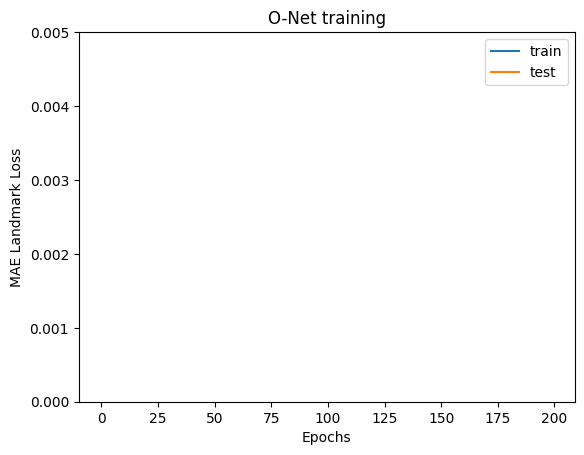

In [16]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.ylim(0, 0.005)
plt.ylabel('MAE Landmark Loss')
plt.xlabel('Epochs')
plt.title('O-Net training')
plt.legend()

In [17]:
best_test_loss

0.01789919100701809